In [1]:
import urllib
import random
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from pybrain.datasets import ClassificationDataSet #cтруктура данных pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError
from pybrain.structure.modules import LinearLayer
import matplotlib.pyplot as plt
%matplotlib inline 
#выполним инициализацию основных используемых модулей

##  Двуслойная нейронная сеть для задачи многоклассовой классификации

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# загрузка файла
f = urllib.request.urlopen(url)
f.readline()  # пропуск заголовочной строки
data = np.loadtxt(f, delimiter=';')
#загрузка данных

In [3]:
TRAIN_SIZE = 0.7 

y = data[:, -1]
np.place(y, y < 5, 5)
np.place(y, y > 7, 7) #приводим задачу к трехклассовой
y -= min(y)
X = data[:, :-1]
X = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=0)
#разделение данных на обучающую и контрольную части в пропорции 70/30%

### Двуслойная нейронная сеть

Функция распознавания, которая може быть записана в виде следующей суперпозиции:
$f(x,W)=h^{(2)}\left(\sum\limits_{i=1}^D w_i^{(2)}h^{(1)}\left(\sum\limits_{j=1}^n w_{ji}^{(1)}x_j+b_i^{(1)}\right)+b^{(2)}\right)$, где

$x$ -- исходный объект (сорт вина, описанный 11 признаками), $x_j$ -- соответствующий признак,

$n$ --  количество нейронов во входном слое сети, совпадающее с количеством признаков,

$D$ --  количество нейронов в скрытом слое сети,

$w_i^{(2)}, w_{ji}^{(1)}, b_i^{(1)}, b^{(2)}$ --  параметры сети, соответствующие весам нейронов,

$h^{(1)}, h^{(2)}$ -- функции активации.

В качестве функции активации на скрытом слое сети используется линейная функция. На выходном слое сети используется функция активации softmax, являющаяся обобщением сигмоидной функции на многоклассовый случай:

$y_k=\text{softmax}_k(a_1,...,a_k)=\frac{\exp(a_k)}{\sum_{k=1}^K\exp(a_k)}.$

### Настройка параметров сети


Оптимальные параметры сети $W_{opt}$ определяются путем минимизации функции ошибки:

$W_{opt}=\arg\min\limits_{W}L(W)+\lambda\|W\|^2$.

Здесь $L(W)$ является функцией ошибки многоклассовой классификации,

$L(W)=- \sum^N_{n=1}\sum^K_{k=1} t_{kn} log(y_{kn}),$

$t_{kn}$ -- бинарно закодированные метки классов, $K$ -- количество меток, $N$ -- количество объектов,

а $\lambda\|W\|^2$ является регуляризующим слагаемым, контролирующим суммарный вес параметров сети и предотвращающий эффект переобучения.

Оптимизация параметров выполняется методом обратного распространения ошибки (backpropagation).

In [4]:
#определение основных констант
HIDDEN_NEURONS_NUM = 100 # количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # максимальное число итераций алгоритма оптимизации параметров сети

In [5]:
# конвертация данных в структуру ClassificationDataSet
# Обучающая часть
ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
# Первый аргумент -- количество признаков np.shape(X)[1], второй аргумент -- количество меток классов len(np.unique(y_train)))
ds_train.setField('input', X_train) # Инициализация объектов
ds_train.setField('target', y_train[:, np.newaxis]) # Инициализация ответов; np.newaxis создает вектор-столбец
ds_train._convertToOneOfMany( ) # Бинаризация вектора ответов
# Контрольная часть
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

In [6]:
np.random.seed(0) #зафиксируем seed для получения воспроизводимого результата

# Построение сети прямого распространения (Feedforward network)
net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer)
# ds.indim -- количество нейронов входного слоя, равне количеству признаков
# ds.outdim -- количество нейронов выходного слоя, равное количеству меток классов
# SoftmaxLayer -- функция активации, пригодная для решения задачи многоклассовой классификации

init_params = np.random.random((len(net.params))) # Инициализируем веса сети для получения воспроизводимого результата
net._setParameters(init_params)

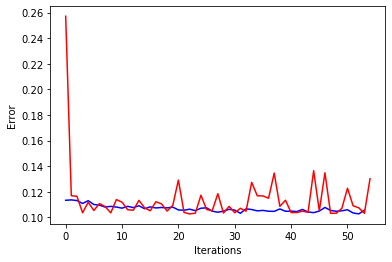

In [7]:
random.seed(0)
# Модуль настройки параметров pybrain использует модуль random; зафиксируем seed для получения воспроизводимого результата
trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')

In [8]:
res_train = net.activateOnDataset(ds_train).argmax(axis=1) # Подсчет результата на обучающей выборке
print ('Error on train: ', percentError(res_train, ds_train['target'].argmax(axis=1)), '%') # Подсчет ошибки
res_test = net.activateOnDataset(ds_test).argmax(axis=1) # Подсчет результата на тестовой выборке
print ('Error on test: ', percentError(res_test, ds_test['target'].argmax(axis=1)), '%' ) # Подсчет ошибки

Error on train:  51.29579982126899 %
Error on test:  46.666666666666664 %


### Определение оптимального числа нейронов

700

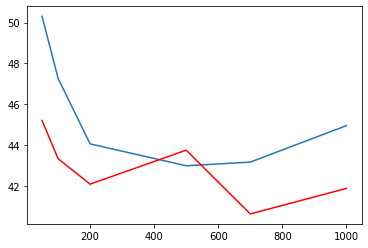

In [9]:
random.seed(0) # Зафиксируем seed для получния воспроизводимого результата
np.random.seed(0)

def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):
# hidden_neurons_num -- массив размера h, содержащий количество нейронов, по которому предполагается провести перебор,
#   hidden_neurons_num = [50, 100, 200, 500, 700, 1000];
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на обучении;
# res_train_vec -- массив размера h, содержащий значения доли неправильных ответов классификации на контроле
    plt.figure()
    plt.plot(hidden_neurons_num, res_train_vec)
    plt.plot(hidden_neurons_num, res_test_vec, '-r')

hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
res_train_vec = list()
res_test_vec = list()

for nnum in hidden_neurons_num:
    net = buildNetwork(ds_train.indim, nnum, ds_train.outdim, outclass=SoftmaxLayer, hiddenclass = LinearLayer)
    init_params = np.random.random((len(net.params))) # Инициализируем веса сети для получения воспроизводимого результата
    net._setParameters(init_params)
    trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=50)
    res_train = net.activateOnDataset(ds_train).argmax(axis=1)
    res_test = net.activateOnDataset(ds_test).argmax(axis=1)
    res_train_vec.append(percentError(res_train, ds_train['target'].argmax(axis=1)))
    res_test_vec.append(percentError(res_test, ds_test['target'].argmax(axis=1)))

    
# Постройте график зависимости ошибок на обучении и контроле в зависимости от количества нейронов
plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec)          
# Количество нейронов, при котором достигается минимум ошибки на контроле
hidden_neurons_num[res_test_vec.index(min(res_test_vec))]